In [1]:
import pandas as pd
import numpy as np
import os
import threading
import sys
import time
from utils import utils
import copy
from matplotlib import pyplot as plt
import numpy as np
import random
np.random.seed(1234)
random.seed(1234)

unique_timestamp = list()
for ts in range(0, 43260000, 60000):
    unique_timestamp.append(str(int(ts/60000)))


In [11]:
def detect_microburst(call_rate, window_size, burst_degree):
    burst_ts = list()
    burst_cnt = 0
    burst_detect = 0
    for i in range(window_size, len(call_rate)):
        if burst_detect == 0:
            prev_window_avg = sum(call_rate[i-window_size:i])/window_size
            if call_rate[i] > prev_window_avg * burst_degree:
                burst_cnt += 1
                burst_ts.append(i)
                burst_detect = window_size
        else:
            burst_detect -= 1
    return burst_cnt, burst_ts

def series_string_to_list(series):
    # series = series.tolist()[0]
    to_li = series[1:-1]
    to_li = to_li.split(",")
    to_li = [float(x) for x in to_li]
    return to_li


svc_per_line_df = pd.read_csv("svc_per_line.csv")

''' Count burstness '''
num_burst = list()
burst_timestamp = list()
window_size=5
burst_degree=2
for idx in range(len(svc_per_line_df)):
    rpm = svc_per_line_df.loc[idx, "li"]
    rpm = series_string_to_list(rpm)
    burst_cnt, burst_ts = detect_microburst(rpm, window_size, burst_degree)
    num_burst.append(burst_cnt)
    burst_timestamp.append(burst_ts)
svc_per_line_df["num_burst"] = num_burst
svc_per_line_df["burst_timestamp"] = burst_timestamp
svc_per_line_df = svc_per_line_df.sort_values(by=["num_burst"], ascending=False)
svc_per_line_df = svc_per_line_df.reset_index(drop=True)

''' Burst statistics '''
total_num_burst = svc_per_line_df['num_burst'].sum() # 2703
bursty_svc_df = svc_per_line_df[svc_per_line_df["num_burst"] > 0]
num_bursty_svc = len(bursty_svc_df) # 264 out of 1301
num_all_svc = len(svc_per_line_df) # 264 out of 1301
avg_burst_per_svc = total_num_burst/num_all_svc
avg_burst_per_bursty_svc = total_num_burst/num_bursty_svc
print("num_all_svc: ", num_all_svc)
print("num_bursty_svc: ", num_bursty_svc)
print("total_num_burst: ", total_num_burst)
print("average num of burst per all service during 12 hours: {}".format(avg_burst_per_svc))
print("average num of burst per bursty service during 12 hours: {}".format(avg_burst_per_bursty_svc))
print("average num of burst per all service per hour: {}".format(avg_burst_per_svc/12))
print("average num of burst per bursty service per hour: {}".format(avg_burst_per_bursty_svc/12))
# 1s

num_all_svc:  1043
num_bursty_svc:  285
total_num_burst:  3079
average num of burst per all service during 12 hours: 2.9520613614573348
average num of burst per bursty service during 12 hours: 10.803508771929824
average num of burst per all service per hour: 0.2460051134547779
average num of burst per bursty service per hour: 0.9002923976608187


In [12]:
class WorkloadGenerator:
    def __init__ (self, req_per_sec, total_sec):
        self.request_per_sec = req_per_sec
        self.total_seconds = total_sec
        self.total_num_req = self.request_per_sec * self.total_seconds
        self.total_num_req = int(self.total_num_req)

    def exponential_distribution(self):
        scale_ = (1 / self.request_per_sec) # scale parameter is the inverse of the rate parameter lambda
        exp_dist=np.random.exponential(scale=scale_, size=(self.total_num_req))
        exp_dist_sum = sum(exp_dist)
        total_millisecond = self.total_seconds*1000
        weight = total_millisecond / exp_dist_sum
        norm_exp_dist = [ x*weight for x in exp_dist ] # norm + sec->ms
        # norm_exp_dist = [ (x / sum(exp_dist))*self.total_seconds*1000 for x in exp_dist ] # norm + sec->ms
        # first_request_start_time = 0.0
        # norm_exp_dist.insert(0, first_request_start_time) # For the very first event, 0 second event arrival is inserted.
        
        # print("DEBUG", "")
        # print("DEBUG", "="*40)
        # print("DEBUG", "== Exponential workload statistics ==")
        # print("DEBUG", "="*40)
        # print("DEBUG", "- total num requests: {}".format(self.total_num_req))
        # print("DEBUG", "- sum: {}".format(sum(norm_exp_dist)))
        # print("DEBUG", "- mean interval: {}".format(sum(norm_exp_dist)/len(norm_exp_dist)))
        # print("DEBUG", "- max interval: {}".format(max(norm_exp_dist)))
        # print("DEBUG", "- min interval: {}".format(min(norm_exp_dist)))
        # print("DEBUG", "="*40)
        return norm_exp_dist
    
    def constant_distribution(self):
        dist = [(self.total_seconds/self.total_num_req) * 1000] * self.total_num_req
        # print("DEBUG", "total_num_req: ", self.total_num_req)
        # print("DEBUG", dist)
        # print("DEBUG", "")
        # print("DEBUG", "="*40)
        # print("DEBUG", "== Constant workload statistics ==")
        # print("DEBUG", "="*40)
        # print("DEBUG", "- total num requests: {}".format(self.total_num_req))
        # print("DEBUG", "- sum: {}".format(sum(dist)))
        # print("DEBUG", "- mean interval: {}".format(sum(dist)/len(dist)))
        # print("DEBUG", "- max interval: {}".format(max(dist)))
        # print("DEBUG", "- min interval: {}".format(min(dist)))
        # print("DEBUG", "="*40)
        return dist

def file_write_float_list(fname, li):
    f_ = open(fname, 'w')
    li = [str(x)+"\n" for x in li]
    f_.writelines(li)
    f_.close()
      

def interval_to_arrival(req_intv):
    req_arrival = list()
    for i in range(len(req_intv)):
        if i == 0:
            req_arrival.append(req_intv[i])
        else:
            req_arrival.append(req_arrival[i-1] + req_intv[i])
    return req_arrival


def request_arrival_to_rps(req_arr):
    rps_list = list()
    rps = 0
    window = 0
    for i in range(1, len(req_arr)):
        rps += 1
        if req_arr[i] >= 1000*window:
            rps_list.append(rps)                    
            rps = 0
            window += 1
    return rps_list

def rps_to_request_arrival_time(rps_list):
    wrk_list = list()
    for rps in rps_list:
        wrk_list.append(WorkloadGenerator(req_per_sec=rps, total_sec=60))
    request_interval = list()
    for i in range(len(wrk_list)):
        request_interval += wrk_list[i].exponential_distribution()
    request_arrival = interval_to_arrival(request_interval)
    print("total num request: ", len(request_arrival))
    print("request_arrival[0]: ", request_arrival[0])
    print("request_arrival[-1]: ", request_arrival[-1])
    return request_arrival

def generate_non_bursty_cluster_workload(target_rps, duration_in_sec):
    wrk = WorkloadGenerator(req_per_sec=target_rps, total_sec=duration_in_sec)
    non_bursty_req_interval = wrk.exponential_distribution()
    req_arr = interval_to_arrival(non_bursty_req_interval)
    return req_arr
    
def new_generate_workload_from_alibaba_trace(rpm):
    def normalize(rps_list, base_rps):
        original_p50_rps = np.percentile(rps_list, 50)
        norm_weight = base_rps/original_p50_rps
        print("original 50p rps: ", original_p50_rps)
        print("target 50p rps: ", base_rps)
        print("norm_weigth: ", norm_weight)
        return [x*norm_weight for x in rps_list]
    
    p50_rpm = np.percentile(rpm, 50) # NOTE: Hardcoded. Apparently, 2 percentile is not p50.
    c0_norm_rps_list = normalize(rpm, 50)
    c0_norm_p10_rps = np.percentile(c0_norm_rps_list, 10)
    c0_norm_p50_rps = np.percentile(c0_norm_rps_list, 50)
    print("original p50_rpm: ", p50_rpm)
    print("norm_p50_rps: ", c0_norm_p50_rps)
    c0_request_arrival = rps_to_request_arrival_time(c0_norm_rps_list)
    print("p50_rps_of_bursty_cluster: ", np.percentile(c0_norm_rps_list, 50))
    c1_request_arrival = generate_non_bursty_cluster_workload(c0_norm_p50_rps, len(c0_norm_rps_list)*60)
    c0_rps = request_arrival_to_rps(c0_request_arrival)
    c1_rps = request_arrival_to_rps(c1_request_arrival)
    plt.plot(c0_rps)
    plt.title("cluster 0-RPS")
    plt.show()
    plt.plot(c1_rps)
    plt.title("cluster 1-RPS")
    plt.show()
    return c0_request_arrival, c1_request_arrival


original 50p rps:  85.06666666666669
target 50p rps:  50
norm_weigth:  0.5877742946708462
original p50_rpm:  85.06666666666669
norm_p50_rps:  50.0
total num request:  2825005
request_arrival[0]:  18.793390329950117
request_arrival[-1]:  43200000.000001796
p50_rps_of_bursty_cluster:  50.0


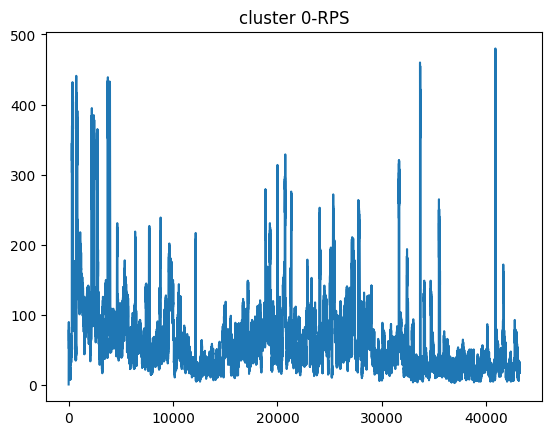

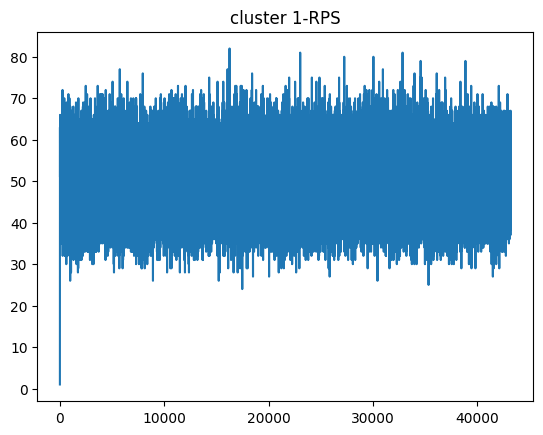

In [13]:


msname_8 = "6d9c26b9"


rpm = svc_per_line_df[svc_per_line_df["msname-8"] == msname_8]["li"].tolist()[0]
rpm = series_string_to_list(rpm)
c0_request_arrival, c1_request_arrival = new_generate_workload_from_alibaba_trace(rpm)
fn_0 = "new_request_arrival_time_clsuter_0-"+msname_8+".txt"
fn_1 = "new_request_arrival_time_clsuter_1-"+msname_8+".txt"
file_write_float_list(fn_0, c0_request_arrival)
file_write_float_list(fn_1, c1_request_arrival)

# # 6s


### When there is only cluster0 request arrival time file.

In [ ]:
def generate_non_bursty_from_bursty(c0_request_arrival):
    c0_rps = request_arrival_to_rps(c0_request_arrival)
    c0_p50_rps = np.percentile(c0_rps, 50)
    print("original p50_rps: ", c0_p50_rps)
    print("c0 seconds: ", len(c0_rps))
    c1_request_arrival = generate_non_bursty_cluster_workload(c0_p50_rps, len(c0_rps))
    c0_rps = request_arrival_to_rps(c0_request_arrival)
    c1_rps = request_arrival_to_rps(c1_request_arrival)
    plt.plot(c0_rps)
    plt.title("cluster 0-RPS")
    plt.show()
    plt.plot(c1_rps)
    plt.title("cluster 1-RPS")
    plt.show()
    return c1_request_arrival


with open("../request_arrival_time/request_arrival_time_6d9c26b9_burst_40_high.txt", "r") as f_:
    lines = f_.readlines()
    c0_request_arrival = list()
    for i in range(len(lines)):
        c0_request_arrival.append(float(lines[i]))
    c1_req_arr = generate_non_bursty_from_bursty(c0_request_arrival)
    with open("c1-request_arrival_time_6d9c26b9_burst_40_high.txt", "w") as f_c1:
        temp_list = list()
        for elem in c1_req_arr:
            temp_list.append(str(elem)+"\n")
        f_c1.writelines(temp_list)


### Deprecated functions

In [ ]:
def generate_msname_metric_df(df_, msname_list_):
    msname_provider_mcr_ = dict()
    for msname_ in msname_list_:
        msname_provider_mcr_[msname_] = list()
        msname_df_ = df_[df_["msname"] == msname_]
        for ts in unique_timestamp:
            temp_df_ = msname_df_[msname_df_['timestamp'] == ts]
            temp_df_ = temp_df_[temp_df_["metric"] == "providerRPC_MCR"]
            msname_provider_mcr_[msname_].append(temp_df_)
    # msname_provider_mcr_ => { msname : [mcr at t=0, mcr at t=1, ...]}
    return msname_provider_mcr_


def get_statistics(li_):
    temp_li = list()
    temp_li.append(len(li_))
    temp_li.append(sum(li_))
    temp_li.append(np.average(li_))
    temp_li.append(np.std(li_))
    temp_li.append(min(li_))
    temp_li.append(max(li_))
    if min(li_) == 0:
        temp_li.append(float('inf'))
    else:
        temp_li.append(max(li_)/min(li_))
    if np.percentile(li_, 1) == 0:
        temp_li.append(float('inf'))
    else:
        temp_li.append(max(li_)/np.percentile(li_, 1))
    temp_li.append(np.percentile(li_, 0.1))
    temp_li.append(np.percentile(li_, 1))
    temp_li.append(np.percentile(li_, 5))
    temp_li.append(np.percentile(li_, 10))
    temp_li.append(np.percentile(li_, 25))
    temp_li.append(np.percentile(li_, 50))
    temp_li.append(np.percentile(li_, 75))
    temp_li.append(np.percentile(li_, 90))
    temp_li.append(np.percentile(li_, 95))
    temp_li.append(np.percentile(li_, 99))
    temp_li.append(np.percentile(li_, 99.9))
    return temp_li

def generate_stat_df(msname_provider_mcr_, msname_, output_df_):
    for i in range(len(unique_timestamp)):
        temp_df = msname_provider_mcr_[msname_][i]
        v_ = temp_df["value"].values.tolist()
        if sum(v_) == -1:
            continue
        if  -1 in v_:
            v_.remove(-1)
        temp_row = [msname_, str(unique_timestamp[i])]
        if len(v_) != 0:
            stats = get_statistics(v_)
            temp_row.extend(stats)
            output_df_.loc[len(output_df_.index)] = temp_row
        else:
            continue

def request_arrival_to_rps(req_arr):
    rps_list = list()
    rps = 0
    window = 0
    for i in range(1, len(req_arr)):
        rps += 1
        if req_arr[i] >= 1000*window:
            rps_list.append(rps)                    
            rps = 0
            window += 1
    return rps_list

def thin_the_request_arrival_list(req_arr, target_rps):
    rps_list = request_arrival_to_rps(req_arr)
    p2_rps = np.percentile(rps_list, 2) # NOTE: Hardcoded. Apparently, 2 percentile is not p50.
    p50_rps = np.percentile(rps_list, 50) # NOTE: Hardcoded. Apparently, 2 percentile is not p50.
    norm_weight = p2_rps/target_rps
    print("original p2_rps: ", p2_rps)
    print("original p50_rps: ", p50_rps)
    print("target_p2_rps: ", target_rps)
    print("norm_weight: ", norm_weight)
    thin_req_arr = list()
    for i in range(len(req_arr)):
        if i%norm_weight==0:
            thin_req_arr.append(req_arr[i])
            
    new_rps_list = request_arrival_to_rps(thin_req_arr)
    new_p2_rps = np.percentile(new_rps_list, 2) 
    new_p50_rps = np.percentile(new_rps_list, 50)
    print("new_p2_rps: ", new_p2_rps)
    print("new_p50_rps: ", new_p50_rps)
    return thin_req_arr

def calc_initial_one_service_num_replica(rps_list, factor):
    first_five_minute_rps = rps_list[:1]
    avg_rps = sum(first_five_minute_rps)/len(first_five_minute_rps)
    per_replica_capacity = 10 # 100ms processing time
    initial_num_replica = int((avg_rps/per_replica_capacity) * factor)
    return initial_num_replica

